1. Use any binary classification dataset
2. Define validation strategy and use it for all next steps without changes
3. Train decision tree model and estimate performance on validation
4. Train bagging model with decision tree as a base model and estimate performance on validation
5. Write your own bagging implementation:
  <br>5.1. Define init for our CustomBaggingClassifier
  <br>5.2. Write fit as described in lecture: divide train data on n parts (`n_estimators` in CustomBaggingClassifier), train `base_estimator` on each part and save these models inside class
  <br>5.3. For predictions we should use all saved models and combine their predictions (as voting)
6. Compare performance of sklearn bagging model with your own implementation

In [15]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.base import clone
import warnings
from sklearn.exceptions import ConvergenceWarning

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Suppress convergence warnings globally
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [16]:
csv_train = r'https://drive.usercontent.google.com/download?id=1RIKv1X_XWYAPCsmH6UPKOue3nHu1pkGJ&export=download&authuser=0'
csv_test = r'https://drive.usercontent.google.com/download?id=1dNHk0lq04yQDpfz3_lf4PX2rZEQWrHnp&export=download&authuser=0&confirm=t&uuid=668130f8-48df-4ba3-ac54-d187c7f65b60&at=AO7h07cWJg4cofkmU9mkqR7XAEl7:1724719828412'

train_raw = pd.read_csv(csv_train)
test_raw = pd.read_csv(csv_test)

train_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [17]:
train_raw_missing_values = train_raw.isnull().sum()
print(train_raw_missing_values[train_raw_missing_values > 0])

Age         177
Cabin       687
Embarked      2
dtype: int64


In [18]:
test_raw_missing_values = test_raw.isnull().sum()
print(test_raw_missing_values[test_raw_missing_values > 0])

Age       86
Fare       1
Cabin    327
dtype: int64


In [19]:
age_mean_train = train_raw['Age'].mean()
embarked_top_train = train_raw['Embarked'].value_counts().index[0]
fare_mean_train = train_raw['Fare'].mean()

pclass_fare = {
    1: 30,
    2: 12,
    3: 7
}

def enhance_features(data):
    data = data.copy().set_index('PassengerId')
        
    data['missing_age'] = data['Age'].isnull().astype(int)
    data['missing_fare'] = data['Fare'].isnull().astype(int)
    data['missing_embarked'] = data['Embarked'].isnull().astype(int)
    data['missing_cabin'] = data['Cabin'].isnull().astype(int)
    
    data['title'] = data['Name'].str.extract(r'[^,]*, ([^.]*)\. .*')
    data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')    
    data['cabin_letter'] = data['Cabin'].str.extract(r'([A-Za-z]*)\d*')
    
    data['Age'] = data['Age'].fillna(age_mean_train)
    data['Fare'] = data['Fare'].fillna(fare_mean_train)    
    data['Embarked'] = data['Embarked'].fillna(embarked_top_train)
    data['cabin_letter'] = data['cabin_letter'].fillna('Unknown')
    
    data['fare_per_person'] = data['Pclass'].map(pclass_fare)
    data['people_per_ticket'] = (data['Fare'] / data['fare_per_person']).round().astype(int)
    data['is_zero_price'] = (data['Fare'] == 0).round().astype(int)
    
    data['family_size'] = data['SibSp'] + data['Parch'] + 1
    
    return data.drop(columns=['Name', 'Ticket', 'Cabin', 'fare_per_person', 'Fare', 'SibSp', 'Parch'])

train_X = enhance_features(train_raw.drop(columns=['Survived']))
train_y = train_raw['Survived']

train_X

<>:20: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
C:\Users\De\AppData\Local\Temp\ipykernel_8136\2445804592.py:20: SyntaxWarning: invalid escape sequence '\.'
  data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')


,Pclass,Sex,Age,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter,people_per_ticket,is_zero_price,family_size
PassengerId,,,,,,,,,,,,,,
1,3,male,22.000000,S,0,0,0,1,Mr,A/5,Unknown,1,0,2
2,1,female,38.000000,C,0,0,0,0,Mrs,PC,C,2,0,2
3,3,female,26.000000,S,0,0,0,1,Miss,STON/O2,Unknown,1,0,1
4,1,female,35.000000,S,0,0,0,0,Mrs,,C,2,0,2
5,3,male,35.000000,S,0,0,0,1,Mr,,Unknown,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,27.000000,S,0,0,0,1,Rev,,Unknown,1,0,1
888,1,female,19.000000,S,0,0,0,0,Miss,,B,1,0,1
889,3,female,29.699118,S,1,0,0,1,Miss,W/C,Unknown,3,0,4


In [20]:
test_X = enhance_features(test_raw)
test_X

,Pclass,Sex,Age,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter,people_per_ticket,is_zero_price,family_size
PassengerId,,,,,,,,,,,,,,
892,3,male,34.500000,Q,0,0,0,1,Mr,,Unknown,1,0,1
893,3,female,47.000000,S,0,0,0,1,Mrs,,Unknown,1,0,2
894,2,male,62.000000,Q,0,0,0,1,Mr,,Unknown,1,0,1
895,3,male,27.000000,S,0,0,0,1,Mr,,Unknown,1,0,1
896,3,female,22.000000,S,0,0,0,1,Mrs,,Unknown,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,male,29.699118,S,1,0,0,1,Mr,A5,Unknown,1,0,1
1306,1,female,39.000000,C,0,0,0,0,Dona,PC,C,4,0,1
1307,3,male,38.500000,S,0,0,0,1,Mr,SOTON/OQ,Unknown,1,0,1


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']),
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=1))
])

param_grid = [
  {
    "DecisionTreeClassifier__max_depth": [5, 8, 13, 20],
    "DecisionTreeClassifier__min_samples_leaf": [3, 5, 10],
  },
  {
    "DecisionTreeClassifier__max_depth": [1000],
    "DecisionTreeClassifier__min_samples_leaf": [3, 5, 10],
    "DecisionTreeClassifier__max_leaf_nodes": [20, 50, 100],
  },  
]

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
scoring=make_scorer(accuracy_score)

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=12)
grid_search.fit(train_X, train_y)

DecisionTree_best_params_ = {k.replace('DecisionTreeClassifier__', ''): v for k, v in grid_search.best_params_.items()}
DecisionTree_cv_score_ = grid_search.best_score_
DecisionTree_train_score_ = accuracy_score(grid_search.predict(train_X), train_y)

print('DecisionTree')
print('Best_params', DecisionTree_best_params_)
print(f'accuracy score on cross-validation: {DecisionTree_cv_score_}')
print(f'accuracy score on all train data: {DecisionTree_train_score_}')

DecisionTree
Best_params {'max_depth': 5, 'min_samples_leaf': 3}
accuracy score on cross-validation: 0.8226716604244695
accuracy score on all train data: 0.8507295173961841


<>:11: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
C:\Users\De\AppData\Local\Temp\ipykernel_8136\3461855959.py:11: SyntaxWarning: invalid escape sequence '\P'
  os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'


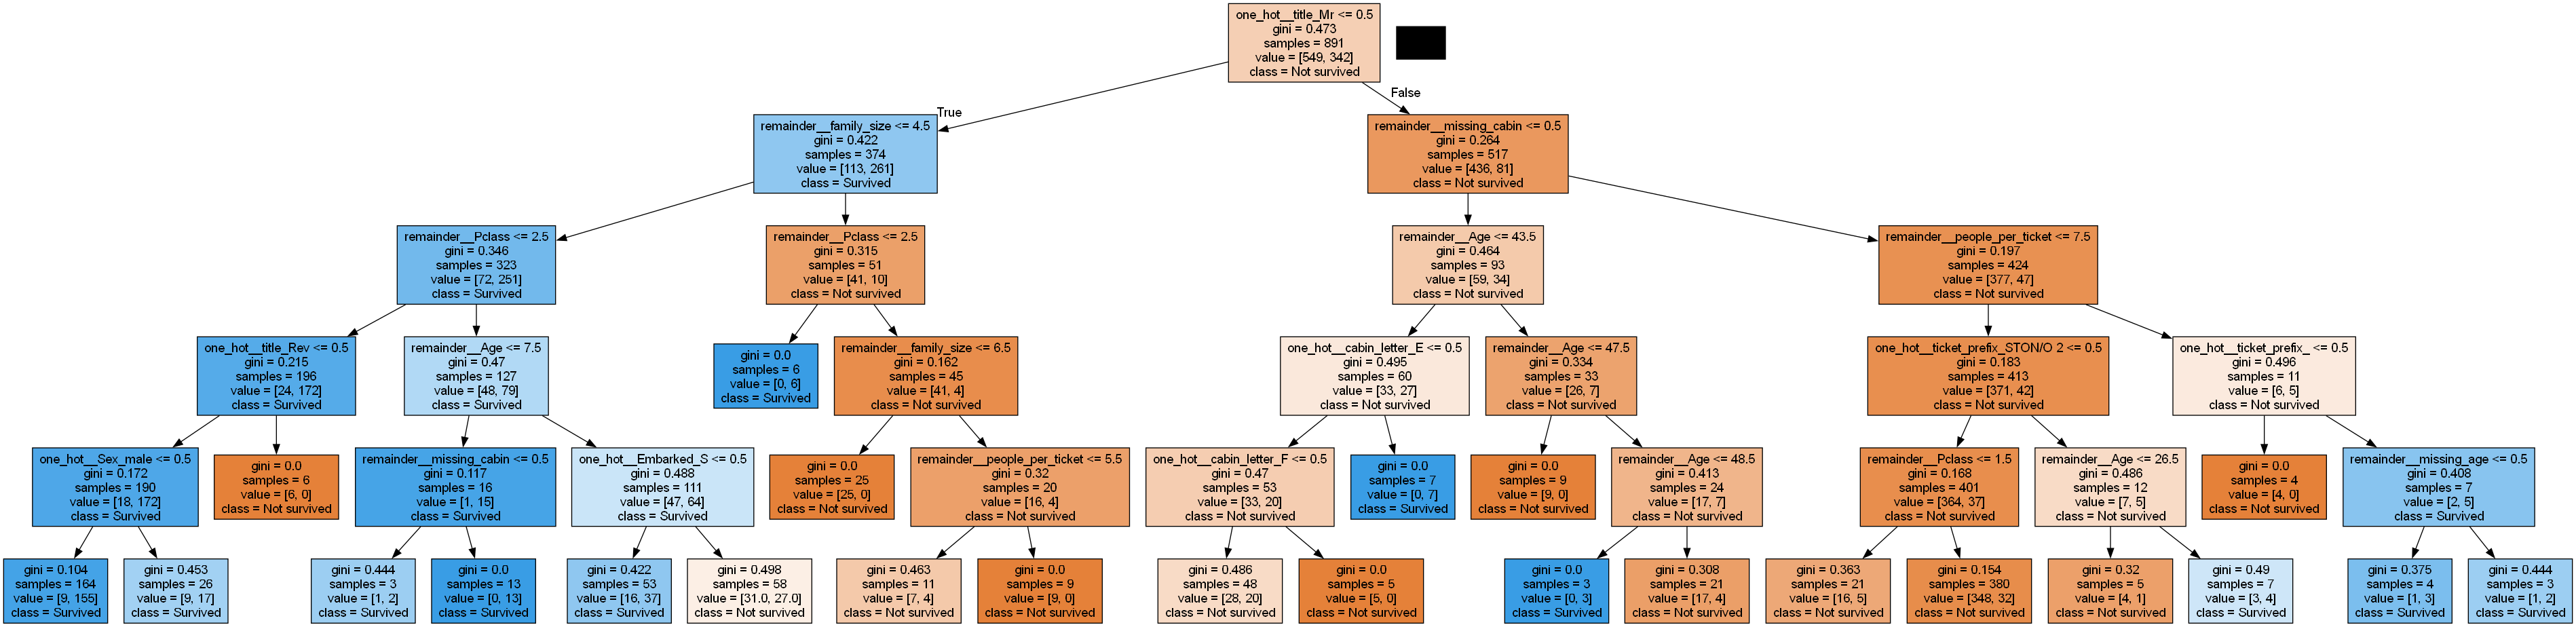

In [22]:
# pip install GraphViz
# pip install pydotplus

from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from six import StringIO

# Windows-only fix
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'

features = grid_search.best_estimator_['Preprocessor'].get_feature_names_out()

dot_data = StringIO()
export_graphviz(
    grid_search.best_estimator_['DecisionTreeClassifier'],
    feature_names=features,
    out_file=dot_data,
    class_names=['Not survived', 'Survived'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

From the vsiaulization it's clear that Fare feature gives overfit (anchoring to minor changes in values).

It could make sense to restrict the number of minor class samples in a split, e.g don't split [1,20] node.

### Let's see if BaggingClassifier improves result for the same DT  hyperpaarmeters

In [23]:
# Take parameters from the previous step
decision_tree_classifier = DecisionTreeClassifier(random_state=1, **DecisionTree_best_params_)

bagging_classifier = BaggingClassifier(
    decision_tree_classifier,
    random_state=3
)

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('BaggingClassifier', bagging_classifier)
])

param_grid = {
    'BaggingClassifier__n_estimators': [50, 100, 200],
    'BaggingClassifier__max_samples': [0.6, 0.7, 0.9],
    'BaggingClassifier__max_features': [0.7, 0.8, 0.9],
}

grid_search2 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=12)
grid_search2.fit(train_X, train_y)


BaggingClassifier_best_params_ = {k.replace('BaggingClassifier__', ''): v for k, v in grid_search2.best_params_.items()}
BaggingClassifier_cv_score_ = grid_search2.best_score_
BaggingClassifier_train_score_ = accuracy_score(grid_search2.predict(train_X), train_y)

print('BaggingClassifier')
print('Best_params', BaggingClassifier_best_params_)
print(f'accuracy score on cross-validation: {BaggingClassifier_cv_score_}')
print(f'accuracy score on all train data: {BaggingClassifier_train_score_}')

print('\nDecisionTree')
print('Best_params', DecisionTree_best_params_)
print(f'accuracy score on cross-validation: {DecisionTree_cv_score_}')
print(f'accuracy score on all train data: {DecisionTree_train_score_}')


BaggingClassifier
Best_params {'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 200}
accuracy score on cross-validation: 0.8316354556803995
accuracy score on all train data: 0.8574635241301908

DecisionTree
Best_params {'max_depth': 5, 'min_samples_leaf': 3}
accuracy score on cross-validation: 0.8226716604244695
accuracy score on all train data: 0.8507295173961841


BaggingClassifier applied on top of the same DT improves accuracy score on cross-validation and train

## Custom Bagging Classifier

In [24]:
class CustomBaggingClassifier:
    def __init__(self, estimator, n_estimators=10, max_samples=0.5, max_features=1, random_state=1): # Some default values, we'll override them later
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.random_state = random_state
        
        self.estimators_ = []
        self.features_indices_ = []
        
  
    def fit(self, X, y):        
        self.estimators_ = []
        self.samples_indices_ = []
        self.features_indices_ = []
        
        # todo: Check in the allowed range 
        n_sampled_rows = int(X.shape[0] * self.max_samples)
        n_sampled_features = int(X.shape[1] * self.max_features)
        
        rng = np.random.RandomState(self.random_state)
                
        for i in range(self.n_estimators):
            sample_indices = rng.choice(X.shape[0] , size=n_sampled_rows, replace=True)
            feature_indices = rng.choice(X.shape[1], size=n_sampled_features, replace=False)
            
            X_sample = X[sample_indices][:, feature_indices]
            y_sample = y[sample_indices]
                        
            i_estimator = clone(self.estimator)
            i_estimator.fit(X_sample, y_sample)
            
            self.estimators_.append(i_estimator)
            self.features_indices_.append(feature_indices)
            
        return
    
        
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions
    

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], 2))
        
        for i, i_estimator in enumerate(self.estimators_):
            X_sample = X[:, self.features_indices_[i]]
            probas += i_estimator.predict_proba(X_sample)
        
        # Average the probabilities across all estimators
        return probas / self.n_estimators
    

    def get_params(self, **params):
        return {
            'estimator': self.estimator,
            'n_estimators': self.n_estimators,
            'max_samples': self.max_samples,
            'max_features': self.max_features,
            'random_state': self.random_state
        }
    
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
            
        return self

Use best parameters found with standard Bagging implementation

In [25]:
decision_tree_classifier = DecisionTreeClassifier(random_state=1, **DecisionTree_best_params_)

custom_bagging_classifier = CustomBaggingClassifier(
    decision_tree_classifier,
    random_state=3,
    **BaggingClassifier_best_params_
)

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('BaggingClassifier', custom_bagging_classifier)
])

# Let's use the same parameters as the standard bagging found optimal
param_grid = {    
    'BaggingClassifier__n_estimators': [BaggingClassifier_best_params_['n_estimators']],
}

grid_search3 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=1)
grid_search3.fit(train_X, train_y.to_numpy())

CustomBaggingClassifier_cv_score_ = grid_search3.best_score_
CustomBaggingClassifier_train_score_ = accuracy_score(grid_search3.predict(train_X), train_y.to_numpy())

print('CustomBaggingClassifier')
print(f'accuracy score on cross-validation: {CustomBaggingClassifier_cv_score_}')
print(f'accuracy score on all train data: {CustomBaggingClassifier_train_score_}')

print('\nBaggingClassifier')
print(f'accuracy score on cross-validation: {BaggingClassifier_cv_score_}')
print(f'accuracy score on all train data: {BaggingClassifier_train_score_}')

print('\nBagging params', BaggingClassifier_best_params_)
print('Base classifier parameters', DecisionTree_best_params_)

CustomBaggingClassifier
accuracy score on cross-validation: 0.8237827715355805
accuracy score on all train data: 0.8518518518518519

BaggingClassifier
accuracy score on cross-validation: 0.8316354556803995
accuracy score on all train data: 0.8574635241301908

Bagging params {'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 200}
Base classifier parameters {'max_depth': 5, 'min_samples_leaf': 3}


Custom bagging gave slightly lower score than standard bagging

## Random Forest

In [26]:
pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(random_state=3))
])

param_grid = {    
    'RandomForestClassifier__n_estimators': [50, 100, 200],
    'RandomForestClassifier__max_samples': [0.65, 0.75],
    'RandomForestClassifier__max_features': [0.75, 0.85],
    
    'RandomForestClassifier__max_depth':  [5],
    'RandomForestClassifier__min_samples_leaf': [3, 5],
}

grid_search5 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=1)
grid_search5.fit(train_X, train_y.to_numpy())

c:\Python\envs\ds1\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'Embarked',
                                                                          'title',
                                                                          'ticket_prefix',
                                                                          'cabin_letter'])])),
                                       ('RandomForestClassifier',
                                        RandomForestClassifier(random_state=3))]),
             n_jobs=1,
             param_grid={'RandomForestClassifier__max_depth': [5],
                         'RandomForestClassifier__max_features': [0.75, 0.85],
                         'RandomForestClassifier__max_samples': [0.65, 0.75],
                         'RandomForestClassifier__min_samples_leaf': [3, 5],
                         'RandomForestClassifier__n_estimators': [50, 100,
                                                                  200]},
             scoring=make_scorer(accuracy_score, response_method='predict'))

In [27]:
RandomForestClassifier_best_params_ = {k.replace('RandomForestClassifier__', ''): v for k, v in grid_search5.best_params_.items()}
RandomForestClassifier_cv_score_ = grid_search5.best_score_
RandomForestClassifier_train_score_ = accuracy_score(grid_search5.predict(train_X), train_y.to_numpy())

print('RandomForestClassifier')
print('Best_params', RandomForestClassifier_best_params_)
print(f'accuracy score on cross-validation: {RandomForestClassifier_cv_score_}')
print(f'accuracy score on all train data: {RandomForestClassifier_train_score_}')

print('\nCustomBaggingClassifier')
print(f'accuracy score on cross-validation: {CustomBaggingClassifier_cv_score_}')
print(f'accuracy score on all train data: {CustomBaggingClassifier_train_score_}')

print('\nBaggingClassifier')
print(f'accuracy score on cross-validation: {BaggingClassifier_cv_score_}')
print(f'accuracy score on all train data: {BaggingClassifier_train_score_}')

print('\nBagging params', BaggingClassifier_best_params_)
print('Base classifier parameters', DecisionTree_best_params_)

print('\nDecisionTree')
print('Best_params', DecisionTree_best_params_)
print(f'accuracy score on cross-validation: {DecisionTree_cv_score_}')
print(f'accuracy score on all train data: {DecisionTree_train_score_}')

RandomForestClassifier
Best_params {'max_depth': 5, 'max_features': 0.75, 'max_samples': 0.75, 'min_samples_leaf': 3, 'n_estimators': 100}
accuracy score on cross-validation: 0.8338701622971285
accuracy score on all train data: 0.856341189674523

CustomBaggingClassifier
accuracy score on cross-validation: 0.8237827715355805
accuracy score on all train data: 0.8518518518518519

BaggingClassifier
accuracy score on cross-validation: 0.8316354556803995
accuracy score on all train data: 0.8574635241301908

Bagging params {'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 200}
Base classifier parameters {'max_depth': 5, 'min_samples_leaf': 3}

DecisionTree
Best_params {'max_depth': 5, 'min_samples_leaf': 3}
accuracy score on cross-validation: 0.8226716604244695
accuracy score on all train data: 0.8507295173961841


## Kaggle submission

In [29]:
dt_test_results = test_X.copy()
dt_test_results['Survived'] = grid_search.best_estimator_.predict(test_X)
dt_test_results['Survived'].to_csv('dt_test_results.csv', index=True)

dt_standard_bagging_test_results = test_X.copy()
dt_standard_bagging_test_results['Survived'] = grid_search2.best_estimator_.predict(test_X)
dt_standard_bagging_test_results['Survived'].to_csv('dt_standard_bagging_test_results.csv', index=True)

dt_custom_bagging_test_results = test_X.copy()
dt_custom_bagging_test_results['Survived'] = grid_search3.best_estimator_.predict(test_X)
dt_custom_bagging_test_results['Survived'].to_csv('dt_custom_bagging_test_results.csv', index=True)

dt_random_forest_test_results = test_X.copy()
dt_random_forest_test_results['Survived'] = grid_search5.best_estimator_.predict(test_X)
dt_random_forest_test_results['Survived'].to_csv('dt_random_forest_test_results.csv', index=True)

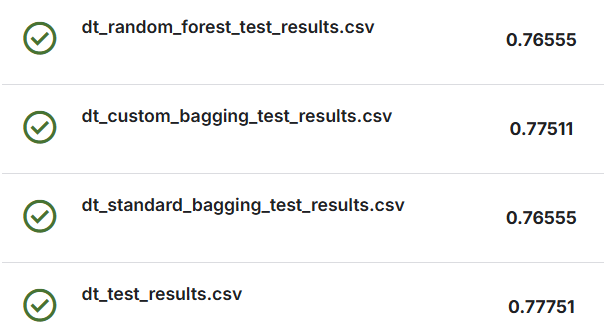